In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pyart

from prepro.nexrad import compute_nexrad_wave_form
from prepro.nexrad import prune_nexrad
from cappi.azran import indexed_vv_to_cappi_amsl, indexed_vv_to_cappi_agl
from cappi.xy_cappi import azran_to_xy
from cappi.make_vv import get_indexed_vv
from cappi.helpers import smooth_radar_field
from config import _EXAMPLEDATA_DIR


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### (i) load and prune raw volume data

In [2]:
filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KOAX20140603_213649_V06.gz')
radar_vol = pyart.io.read_nexrad_archive(filename)
nexrad_wave_form = compute_nexrad_wave_form(radar_vol)
prune_actions = ['surv', 'volume']
prune_vol = prune_nexrad(prune_actions, radar_vol)

# some data smoothing
smooth_window = 5
for field in ['differential_reflectivity', 'cross_correlation_ratio']:
    prune_vol.fields[field]['data'] = smooth_radar_field(
        prune_vol.fields[field]['data'],
        window_size=smooth_window)

# add circular depolarization ratio for later
cdr = pyart.retrieve.compute_cdr(prune_vol)
prune_vol.add_field('circular_depolarization_ratio', cdr)

### (ii) convert the raw volume to indexed virtual volume

In [3]:
# all of this works due to a nice cooperation between Norman and Vienna
ds_vv = get_indexed_vv(prune_vol)

2024-11-22 14:23:47,913 [MainThread  ] [INFO ]  1 of 14 current_elev: 0.48
2024-11-22 14:23:48,006 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:23:48,007 [MainThread  ] [INFO ]  2 of 14 current_elev: 0.88
2024-11-22 14:23:48,093 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:23:48,094 [MainThread  ] [INFO ]  3 of 14 current_elev: 1.32
2024-11-22 14:23:48,179 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:23:48,180 [MainThread  ] [INFO ]  4 of 14 current_elev: 1.80
2024-11-22 14:23:48,248 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:23:48,249 [MainThread  ] [INFO ]  5 of 14 current_elev: 2.42
2024-11-22 14:23:48,316 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:23:48,317 [MainThread  ] [INFO ]  6 of 14 current_elev: 3.12
2024-11-22 14:23:48,384 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, nu

### (iii) convert the indexed virtual volume to a AzRan CAPPI

In [4]:
# as an innocent example let's take the -10°C isothermal height (AMSL) on the day we look at
target_height = 5188  # m AMSL
ds_azran = indexed_vv_to_cappi_amsl(ds_vv, target_height)

2024-11-22 14:23:49,096 [MainThread  ] [INFO ]  reminder: using AMSL for target CAPPI height


Text(0.5, 1.0, 'AzRan -10°C CAPPI pure Python')

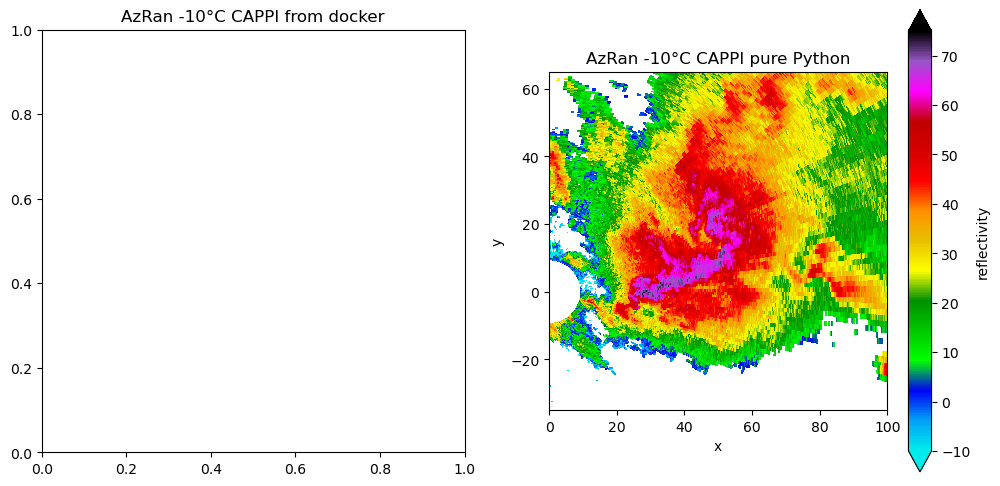

In [5]:
# let's pause a second and compare the results to the MCIT container output

#from hotspots.io import read_azran
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import pyart

timestep = dt.datetime(2014, 6, 3, 21, 36, 50)
# let's assume this is the correct timestep? or is raw volume timestep the end of the sweep and this the beginning?
filelist = [Path(_EXAMPLEDATA_DIR, 'test', "RefCAPPIneg10C_00.00_20140603-213650.netcdf.gz")]

#cappi_docker = read_azran(
#    data_dir, timestep, custom_file_list=filelist, subdir=None)
#display = pyart.graph.RadarDisplay(cappi_docker)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_aspect('equal')
#display.plot_ppi('reflectivity', 0, vmin=-10, vmax=75, cmap='NWSRef', mask_outside=True, ax=ax1, title_flag=False)
#display.set_limits([0, 100], [-35, 65])
ax1.set_title('AzRan -10°C CAPPI from docker')

ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
ds_azran['reflectivity'].plot(x="x", y="y", ax=ax2, vmin=-10, vmax=75, cmap='NWSRef', xlim=(0, 100), ylim=(-35, 65))
ax2.set_title('AzRan -10°C CAPPI pure Python')

### (iv) convert the AzRan CAPPI to xy coordinates

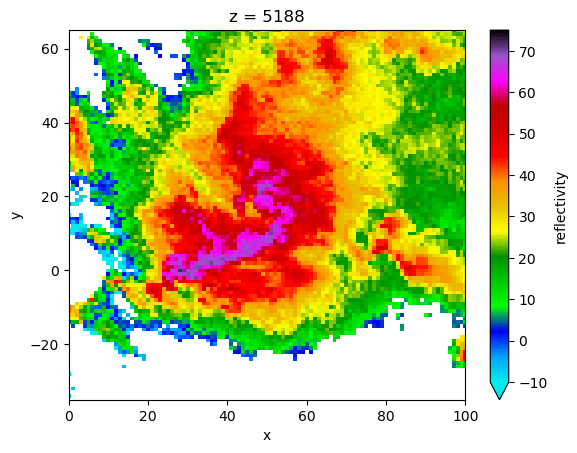

In [6]:
import numpy as np
x_trg = np.arange(-200, 201)
y_trg = np.arange(-200, 201)
ds_grid = azran_to_xy(ds_azran, x_trg, y_trg, grid_spacing_meters=1000.0, max_dist=1.5)

ds_grid['reflectivity'].plot(x="x", y="y", xlim=(0, 100), ylim=(-35, 65), cmap='NWSRef', vmin=-10, vmax=75)

### (v) get the ZDR hotspot field

In [7]:
from hotspots.detection import apply_hotspot_method, get_filtered_zdr

# get ZdrCut for hotspot detection
zdrcut = get_filtered_zdr(ds_grid)
ds_grid["zdr_cut"] = zdrcut

hotspot_field, hotspot_features = apply_hotspot_method(
    ds_grid,
    refl_fieldname='reflectivity',
    zdr_fieldname='zdr_cut', x_dim="x", y_dim="y")


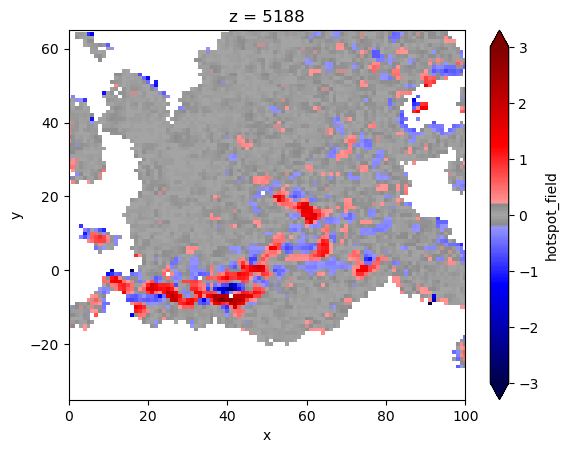

In [8]:
import klaus_krause_cmap
hs_cmap = klaus_krause_cmap.get_hs_cmap(3)
hotspot_field.plot(x="x", y="y", xlim=(0, 100), ylim=(-35, 65), vmin=-3, vmax=3, cmap=hs_cmap)